In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from PIL import Image
from collections import Counter
import json

import warnings
warnings.filterwarnings("ignore")

In [3]:
# Set paths
data_dir = Path("../data/raw/PlantVillage")

# Get all class folders
classes = sorted([d.name for d in data_dir.iterdir() if d.is_dir()])
print(f"Total classes found: {len(classes)}")
print("\nClasses:")
for i, cls in enumerate(classes, 1):
    print(f"{i}. {cls}")

Total classes found: 15

Classes:
1. Pepper__bell___Bacterial_spot
2. Pepper__bell___healthy
3. Potato___Early_blight
4. Potato___Late_blight
5. Potato___healthy
6. Tomato_Bacterial_spot
7. Tomato_Early_blight
8. Tomato_Late_blight
9. Tomato_Leaf_Mold
10. Tomato_Septoria_leaf_spot
11. Tomato_Spider_mites_Two_spotted_spider_mite
12. Tomato__Target_Spot
13. Tomato__Tomato_YellowLeaf__Curl_Virus
14. Tomato__Tomato_mosaic_virus
15. Tomato_healthy


CLASS DISTRIBUTION SUMMARY
                                      Class  Image_Count  Percentage
      Tomato__Tomato_YellowLeaf__Curl_Virus         3208   15.544895
                      Tomato_Bacterial_spot         2127   10.306731
                         Tomato_Late_blight         1908    9.245530
                  Tomato_Septoria_leaf_spot         1771    8.581674
Tomato_Spider_mites_Two_spotted_spider_mite         1676    8.121335
                             Tomato_healthy         1591    7.709454
                     Pepper__bell___healthy         1478    7.161894
                        Tomato__Target_Spot         1404    6.803314
                      Potato___Early_blight         1000    4.845666
                       Potato___Late_blight         1000    4.845666
                        Tomato_Early_blight         1000    4.845666
              Pepper__bell___Bacterial_spot          997    4.831129
                           Tomato_Leaf_Mold          952    4.613074
       

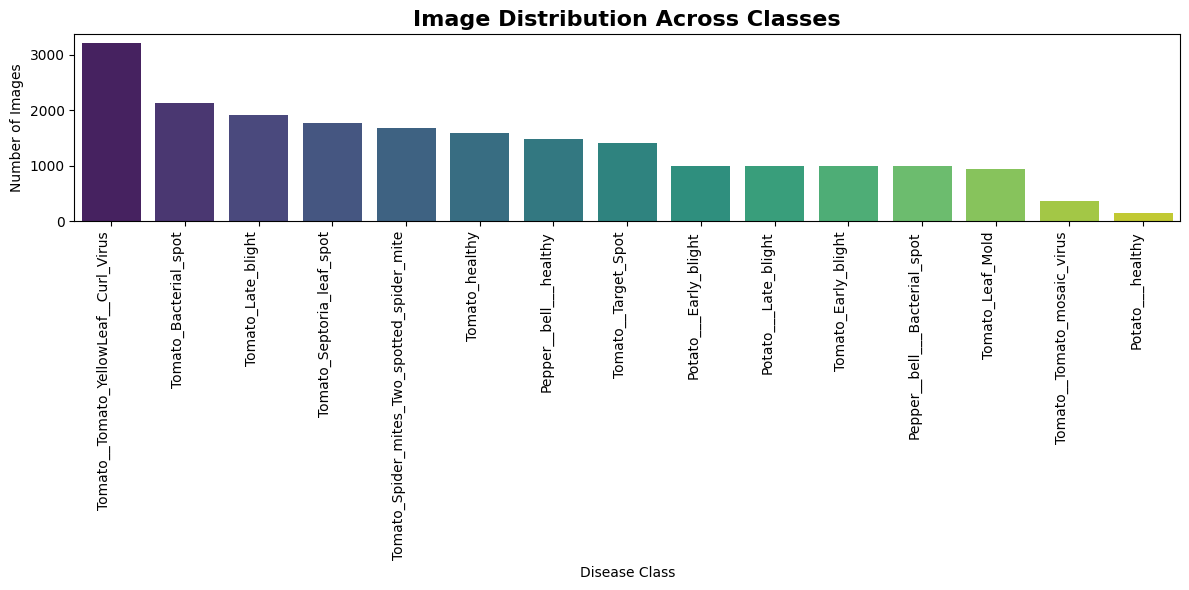


Class Imbalance Ratio: 21.11
⚠️ WARNING: Significant class imbalance detected!
   Consider using class weights during training


In [5]:
# Count images per class
class_counts = {}
all_image_paths = []

for class_name in classes:
    class_path = data_dir / class_name
    images = list(class_path.glob("*.jpg")) + list(class_path.glob("*.JPG")) + \
             list(class_path.glob("*.png")) + list(class_path.glob("*.PNG"))
    class_counts[class_name] = len(images)
    all_image_paths.extend(images)

# Image data summary
df_distribution = pd.DataFrame({
    'Class': list(class_counts.keys()),
    'Image_Count': list(class_counts.values())
})

df_distribution['Percentage'] = (df_distribution['Image_Count'] / df_distribution['Image_Count'].sum()) * 100
df_distribution = df_distribution.sort_values('Image_Count', ascending=False)

print("CLASS DISTRIBUTION SUMMARY")
print(df_distribution.to_string(index=False))
print(f"\nTotal Images: {df_distribution['Image_Count'].sum()}")
print(f"Min images per class: {df_distribution['Image_Count'].min()}")
print(f"Max images per class: {df_distribution['Image_Count'].max()}")
print(f"Mean images per class: {df_distribution['Image_Count'].mean():.2f}")
print(f"Std Dev: {df_distribution['Image_Count'].std():.2f}")

# Visualize class distribution
plt.figure(figsize=(12, 6))
sns.barplot(data=df_distribution, x='Class', y='Image_Count', palette='viridis')
plt.xticks(rotation=90, ha='right')
plt.title('Image Distribution Across Classes', fontsize=16, fontweight='bold')
plt.xlabel('Disease Class')
plt.ylabel('Number of Images')
plt.tight_layout()
plt.savefig('../data/class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# Check for severe class imbalance
max_count = df_distribution['Image_Count'].max()
min_count = df_distribution['Image_Count'].min()
imbalance_ratio = max_count / min_count
print(f"\nClass Imbalance Ratio: {imbalance_ratio:.2f}")
if imbalance_ratio > 3:
    print("⚠️ WARNING: Significant class imbalance detected!")
    print("   Consider using class weights during training")
else:
    print("✓ Classes are reasonably balanced")


Analyzing image properties...

IMAGE PROPERTIES SUMMARY
       width  height  channels  file_size_kb
count  500.0   500.0     500.0    500.000000
mean   256.0   256.0       3.0     16.024164
std      0.0     0.0       0.0      4.292997
min    256.0   256.0       3.0      4.708984
25%    256.0   256.0       3.0     12.872803
50%    256.0   256.0       3.0     16.277344
75%    256.0   256.0       3.0     19.208008
max    256.0   256.0       3.0     27.039062

IMAGE FORMATS
JPEG    500
Name: count, dtype: int64

COLOR MODES
RGB    500
Name: count, dtype: int64

ANOMALY DETECTION

✓ No corrupted images found


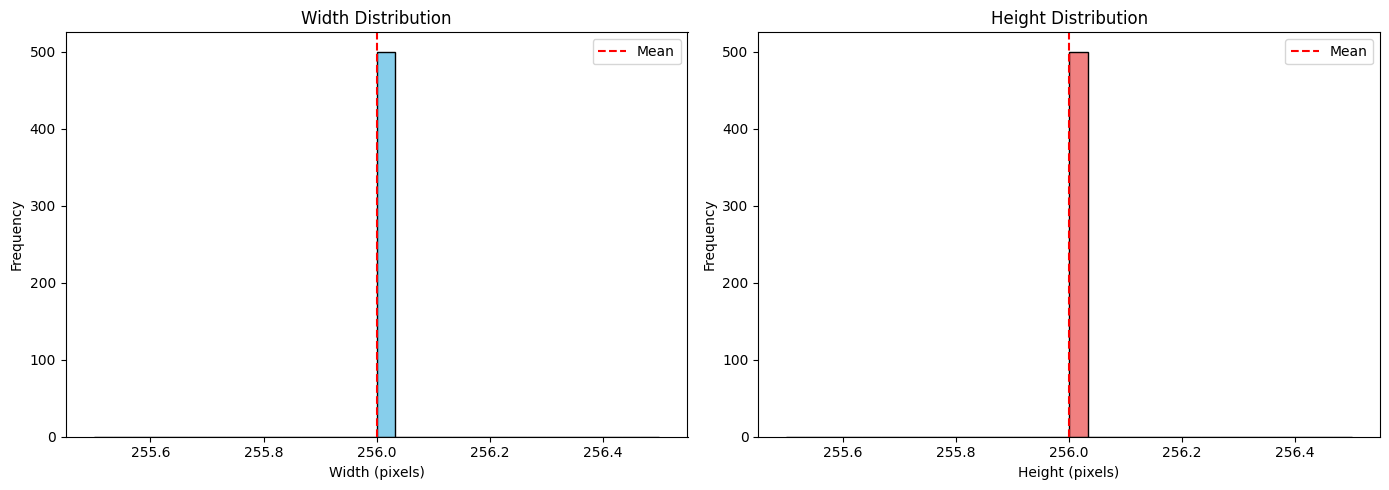

In [6]:
# Sample images to analyze properties
sample_size = min(500, len(all_image_paths))
sample_images = np.random.choice(all_image_paths, sample_size, replace=False)

image_properties = {
    'width': [],
    'height': [],
    'channels': [],
    'file_size_kb': [],
    'format': [],
    'mode': []
}

corrupted_images = []

print("\nAnalyzing image properties...")
for img_path in sample_images:
    try:
        img = Image.open(img_path)
        image_properties['width'].append(img.width)
        image_properties['height'].append(img.height)
        image_properties['mode'].append(img.mode)
        image_properties['format'].append(img.format)
        
        # Count channels
        if img.mode == 'RGB':
            image_properties['channels'].append(3)
        elif img.mode == 'L':
            image_properties['channels'].append(1)
        elif img.mode == 'RGBA':
            image_properties['channels'].append(4)
        else:
            image_properties['channels'].append(len(img.getbands()))
        
        # File size
        file_size = os.path.getsize(img_path) / 1024  # KB
        image_properties['file_size_kb'].append(file_size)
        
        img.close()
    except Exception as e:
        corrupted_images.append((str(img_path), str(e)))
        print(f"❌ Error reading {img_path}: {e}")

# Create summary DataFrame
df_properties = pd.DataFrame(image_properties)

print("\nIMAGE PROPERTIES SUMMARY")
print(df_properties.describe())

print("\nIMAGE FORMATS")
print(pd.Series(image_properties['format']).value_counts())

print("\nCOLOR MODES")
print(pd.Series(image_properties['mode']).value_counts())

# Check for anomalies
print("\nANOMALY DETECTION")

# Unusual dimensions
unusual_width = df_properties[
    (df_properties['width'] < 50) | (df_properties['width'] > 5000)
]
unusual_height = df_properties[
    (df_properties['height'] < 50) | (df_properties['height'] > 5000)
]

if len(unusual_width) > 0:
    print(f"⚠️ Found {len(unusual_width)} images with unusual widths")
if len(unusual_height) > 0:
    print(f"⚠️ Found {len(unusual_height)} images with unusual heights")

# Corrupted images
if corrupted_images:
    print(f"\n Found {len(corrupted_images)} corrupted images:")
    for path, error in corrupted_images:
        print(f"   - {path}: {error}")
else:
    print("\n✓ No corrupted images found")

# Visualize dimensions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(image_properties['width'], bins=30, color='skyblue', edgecolor='black')
axes[0].set_title('Width Distribution')
axes[0].set_xlabel('Width (pixels)')
axes[0].set_ylabel('Frequency')
axes[0].axvline(np.mean(image_properties['width']), color='red', linestyle='--', label='Mean')
axes[0].legend()

axes[1].hist(image_properties['height'], bins=30, color='lightcoral', edgecolor='black')
axes[1].set_title('Height Distribution')
axes[1].set_xlabel('Height (pixels)')
axes[1].set_ylabel('Frequency')
axes[1].axvline(np.mean(image_properties['height']), color='red', linestyle='--', label='Mean')
axes[1].legend()

plt.tight_layout()
plt.savefig('../data/image_dimensions.png', dpi=300)
plt.show()

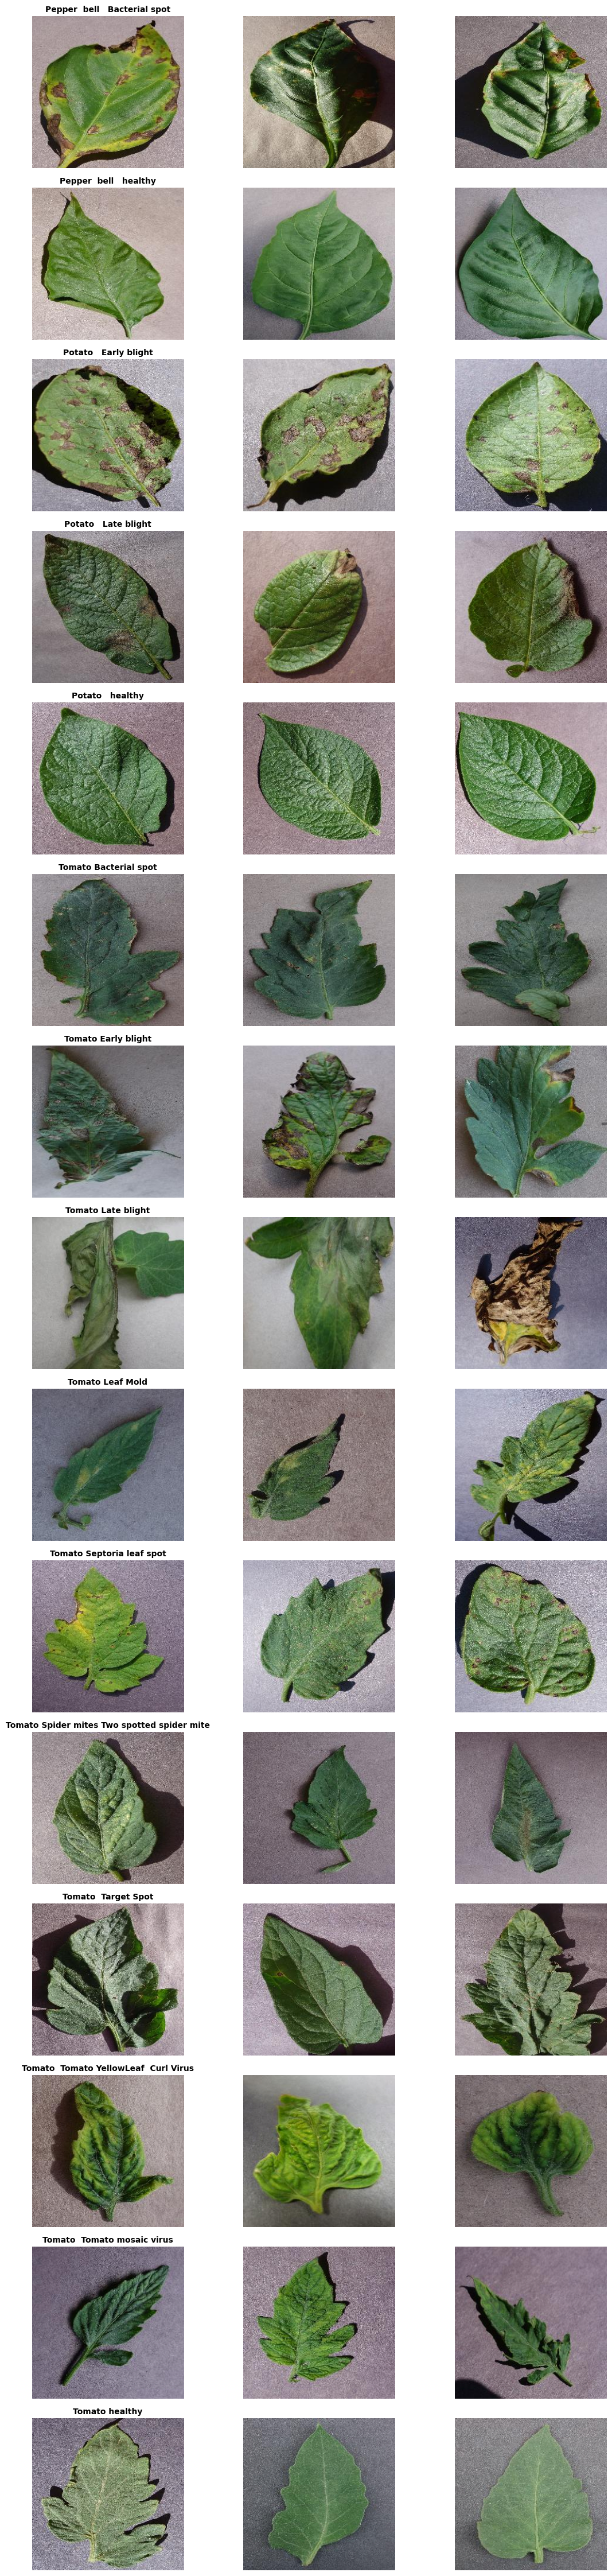

In [7]:
# Display sample images from each class
n_samples = 3
n_classes = len(classes)

fig, axes = plt.subplots(n_classes, n_samples, figsize=(12, n_classes * 3))

for i, class_name in enumerate(classes):
    class_path = data_dir / class_name
    images = list(class_path.glob("*.jpg")) + list(class_path.glob("*.JPG"))
    
    sample_imgs = np.random.choice(images, min(n_samples, len(images)), replace=False)
    
    for j, img_path in enumerate(sample_imgs):
        try:
            img = Image.open(img_path)
            if n_classes == 1:
                ax = axes[j]
            else:
                ax = axes[i, j]
            ax.imshow(img)
            ax.axis('off')
            if j == 0:
                ax.set_title(class_name.replace('_', ' '), fontsize=10, fontweight='bold')
            img.close()
        except Exception as e:
            print(f"Error displaying {img_path}: {e}")

plt.tight_layout()
plt.savefig('../data/sample_images.png', dpi=300, bbox_inches='tight')
plt.show()

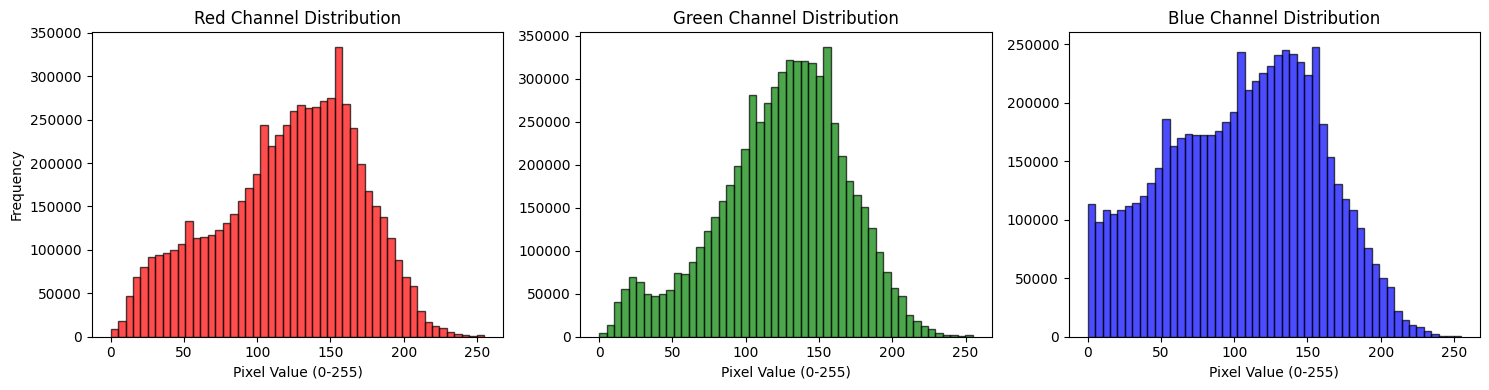


Red Channel - Mean: 120.92, Std: 48.51
Green Channel - Mean: 124.49, Std: 43.60
Blue Channel - Mean: 105.85, Std: 52.07


In [8]:
# Analyze pixel value distribution
sample_for_intensity = np.random.choice(all_image_paths, min(100, len(all_image_paths)), replace=False)

red_values = []
green_values = []
blue_values = []

for img_path in sample_for_intensity:
    try:
        img = Image.open(img_path).convert('RGB')
        img_array = np.array(img)
        
        red_values.extend(img_array[:, :, 0].flatten())
        green_values.extend(img_array[:, :, 1].flatten())
        blue_values.extend(img_array[:, :, 2].flatten())
        
        img.close()
    except Exception as e:
        print(f"Error: {e}")

# Plot pixel distributions
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].hist(red_values, bins=50, color='red', alpha=0.7, edgecolor='black')
axes[0].set_title('Red Channel Distribution')
axes[0].set_xlabel('Pixel Value (0-255)')
axes[0].set_ylabel('Frequency')

axes[1].hist(green_values, bins=50, color='green', alpha=0.7, edgecolor='black')
axes[1].set_title('Green Channel Distribution')
axes[1].set_xlabel('Pixel Value (0-255)')

axes[2].hist(blue_values, bins=50, color='blue', alpha=0.7, edgecolor='black')
axes[2].set_title('Blue Channel Distribution')
axes[2].set_xlabel('Pixel Value (0-255)')

plt.tight_layout()
plt.savefig('../data/pixel_distribution.png', dpi=300)
plt.show()

print(f"\nRed Channel - Mean: {np.mean(red_values):.2f}, Std: {np.std(red_values):.2f}")
print(f"Green Channel - Mean: {np.mean(green_values):.2f}, Std: {np.std(green_values):.2f}")
print(f"Blue Channel - Mean: {np.mean(blue_values):.2f}, Std: {np.std(blue_values):.2f}")

In [10]:
# Save exploration results
metadata = {
    'total_images': int(df_distribution['Image_Count'].sum()),
    'num_classes': len(classes),
    'classes': classes,
    'class_distribution': df_distribution.to_dict('records'),
    'image_properties': {
        'mean_width': float(np.mean(image_properties['width'])),
        'mean_height': float(np.mean(image_properties['height'])),
        'std_width': float(np.std(image_properties['width'])),
        'std_height': float(np.std(image_properties['height'])),
        'common_format': pd.Series(image_properties['format']).mode()[0],
        'common_mode': pd.Series(image_properties['mode']).mode()[0]
    },
    'corrupted_images': corrupted_images,
    'imbalance_ratio': float(imbalance_ratio),
    'recommended_target_size': [224, 224],  # Standard for transfer learning
    'normalization_method': 'rescale_1_255'  # Will divide by 255
}

# Save to JSON
with open('../data/metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)